# Topic Modeling w NMF, SVD

Here's a term-document matrix.
![matrix](images/document_term.png)

We can decompose it into a tall, thin matrix times a wide, short matrix (and poss a diag in between)

We'll try Singular Value Decomposition (SVD) and Non-negaitve Matrix Factorization (NMF)

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

### Data Setup

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [5]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Look at some data. The below is prob from 'comp.graphics'.

In [6]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [8]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], 
      dtype='<U18')

Target attrib is int index of category

In [9]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1], dtype=int64)

In [10]:
num_topics, num_top_words = 6,8

We can use sklearn to extract word counts

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [12]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents,vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [13]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [14]:
vocab = np.array(vectorizer.get_feature_names())

In [15]:
vocab.shape

(26576,)

In [16]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel', 'counselees',
       'counselor', 'count'], 
      dtype='<U80')

## SVD

The SVD algorithm factorizes a matrix into one matrix with orthogonal columns and one with orthogonal rows (along with a diagonal matrix, which contains the relative importance of each factor).

![SVD](images/svd_fb.png)

SVD is an exact decomposition, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations (winning entry for Netflix Prize)
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis (will be covered later in course)

In [17]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

Wall time: 24.4 s


In [18]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [27]:
# now we confirm that U, s, Vh is a decomposition of Vectors
# we can do this with the following.
vectors_reconstructed = np.dot(U * s, Vh)

In [30]:
np.allclose(vectors, vectors_reconstructed)

True

In [42]:
x = np.array([0,1])
y = np.array([0,1])

In [44]:
x @ y

1

Allclose tells us this decomp is good. Let's do it another way.

In [45]:
reconstructed_vectors = U @ np.diag(s) @ Vh
np.linalg.norm(reconstructed_vectors - vectors) # frobenius, sq el't and add all
np.allclose(reconstructed_vectors, vectors) # checks each el't

True

In [31]:
# confirm that U, Vh are orthonormal
product = np.dot(U, Vh)
np.fill_diagonal(product, 0)

In [32]:
product

array([[ 0.        , -0.00005216,  0.00075593, ...,  0.00001956,
         0.00003911,  0.00226399],
       [-0.01180971,  0.        , -0.0005135 , ...,  0.00001167,
         0.00002334,  0.00003739],
       [ 0.0036624 , -0.01258836,  0.        , ..., -0.0000444 ,
        -0.00008879, -0.00015916],
       ..., 
       [-0.00043759, -0.00425605,  0.00074763, ..., -0.00021339,
        -0.00042679,  0.00053759],
       [ 0.00576556,  0.00304193, -0.00002426, ..., -0.00001116,
        -0.00002232, -0.00133598],
       [ 0.00030212,  0.00023288, -0.00002906, ...,  0.00000218,
         0.00000436, -0.00000786]])

In [36]:
product.any() == 0

False

That didn't work. Here's the answer.
Recall what orthonormal/orthogonal is:

An orthogonal matrix is a square matrix whose columns and rows are orthogonal unit vectors (i.e., orthonormal vectors), i.e.

$$ Q^{\mathrm {T} }Q=QQ^{\mathrm {T} }=I, Q^{\mathrm {T} }Q=QQ^{\mathrm {T} }=I, $$
where $ I $ is the identity matrix.

This leads to the equivalent characterization: a matrix Q is orthogonal if its transpose is equal to its inverse:

$${\displaystyle Q^{\mathrm {T} }=Q^{-1}.}$$

In [47]:
# check that getting transpose of U vs V.
# multiply by transpose, then compare to identity
np.allclose(U.T @ U, np.eye(U.shape[0])) # U.T is rows x cols so we get col of U by col of U
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))

True

s, singular values give us measures of importance.  See how these drop off and what relative importance looks like.

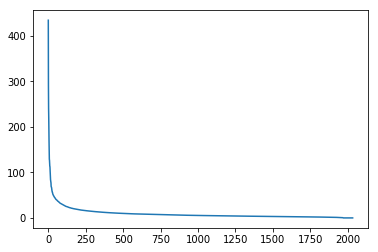

In [37]:
plt.plot(s)

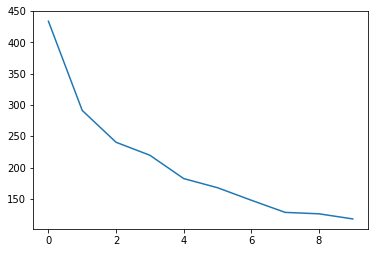

In [38]:
plt.plot(s[:10])

In [48]:
num_top_words = 8

In [51]:
def show_topics(a):
    """
    Pass in our matrix V--this looks up words corresp to values.
    vocab words were in alph order, this finds the largest
    values in cols that corresp to these vocab words
    """
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [50]:
show_topics(Vh[:5]) # get first 5 cols of Vh, top topic words

TypeError: 'function' object is not subscriptable